In [1]:
import argparse
import midi
import os

from constants import *
from dataset import load_all
from generate import write_file, generate
from play_music_util import play_music

import pygame
import base64

# from playsound import playsound
import numpy as np
import copy 

/opt/miniconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import math
import time
from IPython import display
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import optim
%matplotlib inline

import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch

In [4]:
styles = [['data/Bach']]
styles[0]

['data/Bach']

In [5]:
print('Loading data')
X, y = load_all(styles, BATCH_SIZE, SEQ_LEN)

Loading data


In [6]:
X.shape, y.shape 

((5727, 128, 48, 3), (5727, 128, 48, 3))

In [7]:
from model import Generator, iterate_minibatches, compute_loss, train, time_axis

In [8]:
X_tr = X[:-1]
X_te = X[-1:]
y_tr = y[:-1]
y_te = y[-1:]

In [9]:
X_tr.shape, X_te.shape

((5726, 128, 48, 3), (1, 128, 48, 3))

In [10]:
generator = Generator()
generator.cuda()

Generator(
  (time_ax): time_axis(
    (attention_layer): MultiHeadAttention(
      (attention): ScaledDotProductAttention(
        (dropout): Dropout(p=0.1)
      )
      (proj): Linear(in_features=234, out_features=78, bias=True)
      (dropout): Dropout(p=0.1)
    )
    (FF): PositionwiseFeedForward(
      (w_1): Linear(in_features=78, out_features=312, bias=True)
      (w_2): Linear(in_features=312, out_features=78, bias=True)
      (dropout): Dropout(p=0.1)
    )
    (time_lstm): LSTM(94, 256, num_layers=2, batch_first=True, dropout=0.1)
    (dropout): Dropout(p=0.2)
    (generate_features): feature_generation(
      (padding): ZeroPad2d(padding=(11, 12, 0, 0), value=0)
      (conv): Conv1d(3, 64, kernel_size=(24,), stride=(1,))
    )
  )
  (note_ax): note_axis(
    (note_lstm): LSTM(259, 128, num_layers=2, batch_first=True, dropout=0.1)
    (dropout): Dropout(p=0.2)
    (logits): Linear(in_features=158, out_features=3, bias=True)
  )
  (overall_information): track_feature(
    (o

In [11]:
print(generator.note_ax.temperature)
print(generator.note_ax.apply_T)

1
False


Epoch 1 of 20 took 197.003s
current train loss: 0.019411431175367186
current val loss: 0.013873638585209846


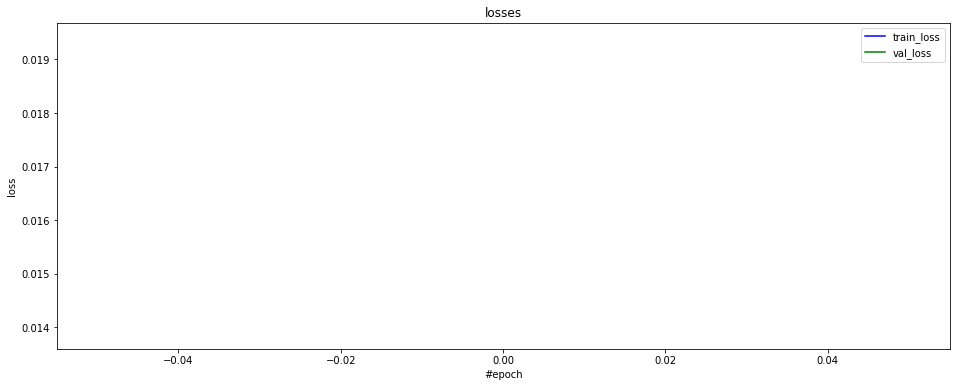

40it [00:01, 31.65it/s]


In [35]:
generator, epoch, epoch_history = train(generator, X_tr, X_te, y_tr, y_te, 
                                 batchsize=1, n_epochs = 20, verbose=True)

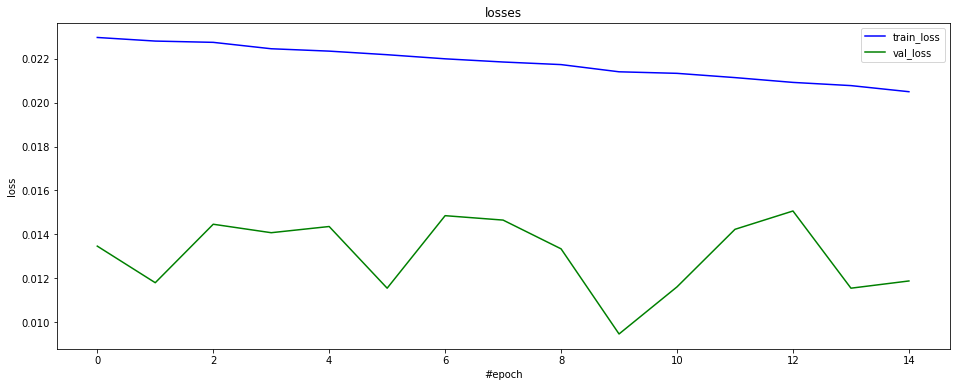

In [27]:
# Visualize
display.clear_output(wait=True)
plt.figure(figsize=(16, 6))

plt.title("losses")
plt.xlabel("#epoch")
plt.ylabel("loss")
plt.plot(epoch_history['train_loss'], 'b', label = 'train_loss')
plt.plot(epoch_history['val_loss'], 'g', label = 'val_loss')
plt.legend()
plt.show()

In [13]:
# generator = Generator()
# generator.cuda()

## Save/load the model

In [50]:
# from model import Generator, iterate_minibatches, compute_loss, train
# torch.save(generator.state_dict(), os.path.join(OUT_DIR, 'model_test2'))
# torch.save(generator.state_dict(), os.path.join(OUT_DIR, 'model_track_featured'))
# torch.save(generator.state_dict(), os.path.join(OUT_DIR, 'model_canonical_attention'))
# the_model = Generator()
# generator = Generator()
# generator.load_state_dict(torch.load(os.path.join(OUT_DIR, 'model_test3')))
generator.load_state_dict(torch.load(os.path.join(OUT_DIR, 'model_test2')))
# generator.load_state_dict(torch.load(os.path.join(OUT_DIR, 'model_track_featured')))


In [51]:
# def generate_sample(generator,batch_size):
#     sound = torch.zeros(batch_size,SEQ_LEN,OCTAVE*NUM_OCTAVES,3).cuda()
#     print(sound.shape)
#     generator.note_ax.to_train = False
#     time_model, note_model, track_feature_model = generator.time_ax, generator.note_ax, generator.overall_information
#     for t in range(SEQ_LEN):
#         note_features = time_model(sound.data)
#         note_features = note_features[:, -1:, :]
# #         print('note_features', note_features.shape)
#         track_features = track_feature_model(sound.data)      
#         current_sound,prob = note_model(note_features, None, track_features)
#     generator.note_ax.to_train = True
#     return prob ,current_sound

In [52]:
# generate_sample(generator, 2)

In [53]:
generator.note_ax.temperature

1

In [54]:
# print(the_model)
# for i in list(the_model.note_ax.note_lstm.parameters()):
#     print(i.shape)

# Canonical

In [55]:
generator.cuda()
generator.eval()
# generator.note_ax.to_train=False
# generator.note_ax.apply_T=False
write_file('output/canonical_test', generate(generator, 16, to_train=True))

  0%|          | 1/256 [00:00<00:47,  5.34it/s]

Generating with no styles:


100%|██████████| 256/256 [00:26<00:00,  9.53it/s]

Writing file out/samples/output/canonical_test_0.mid


In [17]:
write_file('output/canonical_test1', generate(generator, 8, to_train=False))

  2%|▏         | 2/128 [00:00<00:09, 13.01it/s]

Generating with no styles:


100%|██████████| 128/128 [00:05<00:00, 22.24it/s]


Writing file out/samples/output/canonical_test1_0.mid


In [ ]:
# midi_file = 'out/samples/output/canonical_test_0.mid'
# play_music(midi_file)